# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.utils.data as data
from sklearn.metrics import pairwise_distances

import state_inference.utils as utils
from state_inference.data import ObservationDataset
from state_inference.gridworld_env import (
    ObservationModel,
    TransitionModel,
    DiffusionEnv,
    RewardModel
)
from state_inference.model import DEVICE, Decoder, Encoder, StateVae
from state_inference.pytorch_utils import train_epochs
from state_inference.tabular_models import (
    TabularRewardEstimator,
    TabularTransitionEstimator,
    value_iteration,
    OnPolicyCritic, 
    Simulator,
    Sarsa
)
from value_iteration.environments.thread_the_needle import make_thread_the_needle_walls

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.9.16 (main, Mar  8 2023, 04:29:24) 
[Clang 14.0.6 ]
torch 2.0.0
device = mps


# Define the toy world

In [4]:
# Discritized states: a 20x20 grid of states, which we embed by spacing
# evenly in a nXn space
HEIGHT, WIDTH = 20, 20
MAP_HEIGHT = 60

START_STATE = WIDTH * (HEIGHT // 2) + (WIDTH // 4 * 3)  # bottom right corner

gw_kwargs = dict(
    rbf_kernel_size=51, rbf_kernel_scale=0.2, location_noise_scale=0.5  # must be odd
)
observation_model = ObservationModel(HEIGHT, WIDTH, MAP_HEIGHT, **gw_kwargs)


# Define the transitions for the thread the needle task
walls = make_thread_the_needle_walls(20)
transition_model = TransitionModel(HEIGHT, WIDTH, walls)

# Thread the needle reward function
state_rewards = {ii: 1 for ii in range(0, 10)}
state_rewards.update({20 * ii: 1 for ii in range(0, 10)})
state_rewards.update({20 * ii: -1 for ii in range(10, 20)})
reward_model = RewardModel(state_rewards)


# ## define the transition functions for the task
# state_action_transitions = TransitionModel.make_cardinal_transition_function(
#     HEIGHT, WIDTH, walls
# )

## Wrap these in a world model
task = DiffusionEnv(
    transition_model=transition_model,
    reward_model=reward_model,
    observation_model=observation_model,
    initial_state=START_STATE,
    n_states=HEIGHT * WIDTH,
)

print(f"Start grid location: {observation_model.get_grid_coords(START_STATE)}")

Start grid location: (10, 15)


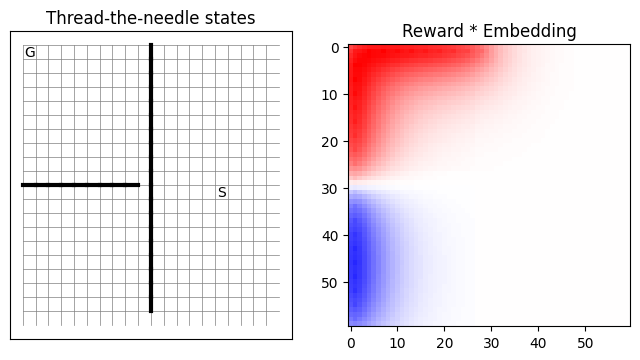

In [5]:
# for Display purposes, we can show the reward function embedded in the original
# space.  This doesn't have a clean interpretation, but it shows us
# roughly where pixels are associated with positive or negative reward

reward_map = (
    torch.stack(
        [
            observation_model.embed_state(s)[None, ...] * r
            for s, r in state_rewards.items()
        ]
    )
    .mean(dim=0)
    .reshape(MAP_HEIGHT, -1)
)

## Display the task
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].invert_yaxis()
transition_model.display_gridworld(ax=axes[0])
axes[0].annotate("G", (0, 0), ha="center", va="center", c="k")
r, c = observation_model.get_grid_coords(START_STATE)
axes[0].annotate("S", (c, r), ha="center", va="center", c="k")
axes[0].set_title("Thread-the-needle states")


_max = max([abs(reward_map.min()), abs(reward_map.max())])
axes[1].imshow(reward_map, cmap="bwr", vmin=-_max, vmax=_max)
axes[1].set_title("Reward * Embedding")
plt.show()

### Pretrain the observation model
For these simulations, we will assume the observation model is known.

In [6]:
### Simulation Parameters
N_TRAINING_EXAMPLES = 10000
BATCH_SIZE = 64


# Create the dataloaders from the dataset
args = [transition_model, observation_model]
train_obs = ObservationDataset(*args, N_TRAINING_EXAMPLES)
test_obs = ObservationDataset(*args, train=False)

train_loader = data.DataLoader(
    train_obs,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = data.DataLoader(test_obs, batch_size=BATCH_SIZE)

11


In [7]:
### Model + Training Parameters
N_EPOCHS = 1  # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(observation_model.states) // 2
OBSERVATION_DIM = observation_model.map_height**2
LR = 3e-4
beta = 1.0
tau = 2.0
gamma = 0.99
dropout = 0.1

# create the model
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS

encoder = Encoder(
    OBSERVATION_DIM,
    encoder_hidden,
    z_dim,
    dropout=dropout,
)

decoder = Decoder(
    z_dim,
    decoder_hidden,
    OBSERVATION_DIM,
    dropout=dropout,
)

vae_kwargs = dict(
    z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS, beta=beta, tau=tau, gamma=gamma
)

vae_model = StateVae(encoder, decoder, **vae_kwargs).to(DEVICE)
print(vae_model)

StateVae(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=3600, out_features=720, bias=True)
      (1): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=720, out_features=360, bias=True)
      (5): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=360, out_features=1000, bias=True)
      (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=1000, out_features=360, bias=True)
      (1): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=360, out_features=720, bias=True)
      (5): BatchNorm1

In [8]:
# Train the the model
train_losses, test_losses = train_epochs(
    vae_model, train_loader, test_loader, dict(epochs=N_EPOCHS, lr=LR, clip_grad=True)
)

Epoch 0, ELBO Loss (test) 3.614109


## Play the game
Simulate an agent in the game world

In [9]:
random_critic = OnPolicyCritic(
    vae_model,
    set_action=set(transition_model.state_action_transitions.keys()),
    gamma=0.8,
    n_iter=1000,
)
sim = Simulator(task, random_critic, max_trial_length=10000)

In [10]:
history = sim.simulate_trial()

In [11]:
history.get_total_reward()

345

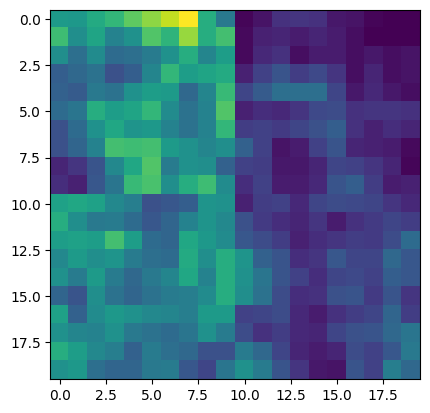

In [12]:
plt.imshow(history.get_visitation_history(h=20, w=20))

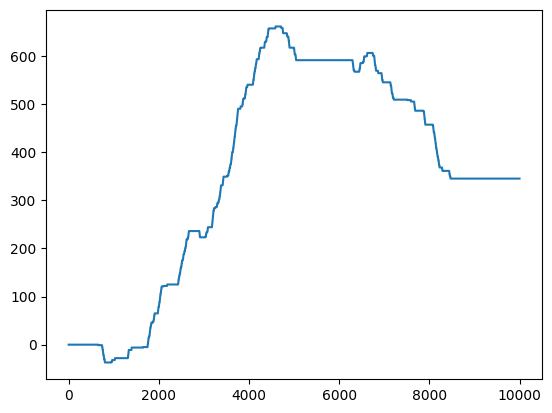

In [13]:
history.plot_cumulative_reward()

In [14]:
len(random_critic.rewards.get_states())

1

In [15]:
q = {k: v for v, k in zip([-10, -2, 4, 3], "a b c d".split())}
print(q)
from scipy.special import logsumexp

z = logsumexp(list(q.values()))
p = {k: np.exp(v - z) for k, v in q.items()}
print(p)

{'a': -10, 'b': -2, 'c': 4, 'd': 3}
{'a': 6.067962512074591e-07, 'b': 0.0018088341315438527, 'c': 0.7297357713172159, 'd': 0.26845478775498877}


In [16]:
from random import choices

choices(list(p.keys()), weights=list(p.values()))

['c']

In [17]:
sarsa = Sarsa(
    vae_model,
    set_action=set(transition_model.state_action_transitions.keys()),
    learning_rate=0.1,
    gamma=0.8,
)
sim = Simulator(task, random_critic, max_trial_length=10000)

In [18]:
history = sim.simulate_trial()

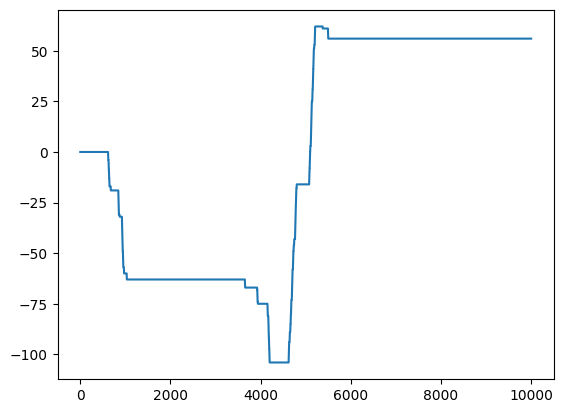

In [19]:
history.plot_cumulative_reward()

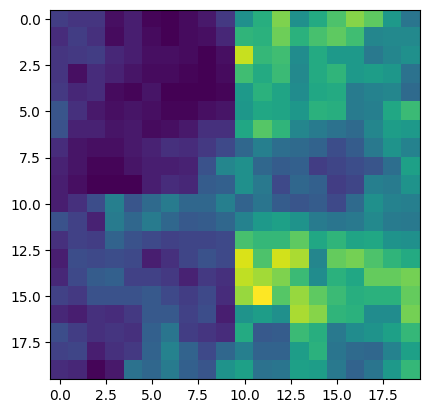

In [20]:
plt.imshow(history.get_visitation_history(h=20, w=20))